# Import Path

In [1]:
import os
import sys

p = os.path.abspath('../')
if p not in sys.path:
    print('Adding {} path to system'.format(p))
    sys.path.append(p)

Adding C:\Cerebral\_MarioSandBox\Python\projectPage_myOntarioCovidModelTrendAnalysis\git_projectCodes\myOntarioCovidModelTrendAnalysis path to system


The [Epidemiological Data from the COVID-19 Outbreak in Canada](https://github.com/ishaberry/Covid19Canada) located in github.



In [2]:
from myFunctions.covid import covid as cvd
import myFunctions.myVis as myVis

In [3]:
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
import optuna
optuna.logging.disable_default_handler()

In [4]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Get Data

## Population Data

In [5]:
provinceDataPopFile = '\data\provincePop.csv'
popData = pd.read_csv(p + provinceDataPopFile)
popData = popData.set_index('province')
popData.head()

,population
province,
Ontario,14446515
Quebec,8433301
British Columbia,5020302
Alberta,4345737
Manitoba,1360396


## COVID Data

In [6]:
covidObject = cvd(cached=True)

Getting COVID data
cached


In [7]:
provOfInterest = 'Ontario'
covidObject.getProcessedData(provOfInterest)

In [8]:
# convert dictionary into dataframe
dfData = pd.DataFrame.from_dict(covidObject.dataProcess)
# convert date col to datetime pandas series
dfData.set_index('date')
dfData['date'] = pd.to_datetime(dfData['date'])
# convert index to dates
dfData = dfData.set_index('date')

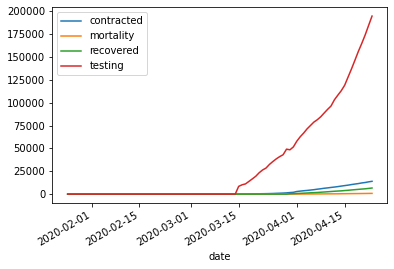

In [9]:
dfData.plot()

In [10]:
dfData.head()

,contracted,mortality,recovered,testing
date,,,,
2020-01-25,1,0,0,0
2020-01-27,2,0,0,0
2020-01-31,3,0,0,0
2020-02-12,3,0,1,0
2020-02-13,3,0,1,0


In [11]:
dfData.tail()

,contracted,mortality,recovered,testing
date,,,,
2020-04-19,11539,602,5209,156097
2020-04-20,12214,651,5515,164840
2020-04-21,12706,697,5806,174170
2020-04-22,13418,757,6221,184531
2020-04-23,13996,798,6680,194745


# SIR Model

### What is SIR model?
SIR model is a simple mathematical model to understand outbreak of infectious diseases.  
[The SIR epidemic model - Learning Scientific Programming with Python](https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/)

 * S: Susceptible (=All - Confirmed)
 * I: Infected (=Confirmed - Recovered - Deaths)
 * R: Recovered or fatal (=Recovered + Deaths)
 
**Note: THE FOLLOWING IMPLEMENTATION IS NOT THE GENERAL MODEL!**
Though R in SIR model is "Recovered and have immunity", the definition of **R here is Recovered or fatal**. This is because mortality rate cannot be ignored in the real COVID-19 data.

Model:  
$$S + I \overset{\beta}{\longrightarrow} 2I  $$
$$I \overset{\gamma}{\longrightarrow} R$$

$\beta$: Transmission/infection rate [1/min]  
$\gamma$: Recovery**(+Mortality)** rate [1/min]  

Ordinary Differential Equation (ODE):   
$\frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta S I$  
$\frac{\mathrm{d}I}{\mathrm{d}T}= N^{-1}\beta S I - \gamma I$  
$\frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I$  

Where $N=S+I+R$ is the total population, $T$ is the elapsed time from the start date.

### Non-dimensional SIR model
To simplify the model, we will remove the units of the variables from ODE.

Set 
$$(S, I, R) = N \times (x, y, z)$$ 
and 
$$(T, \beta, \gamma) = (\tau t, \tau^{-1} \rho, \tau^{-1} \sigma)$$


This results in the ODE: 

| $\frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y$          | $\frac{\mathrm{d}S}{\mathrm{d}t}= - \beta S I $         |
|--------------------------------------------------------|---------------------------------------------------------|
| $\frac{\mathrm{d}y}{\mathrm{d}t}= \rho x y - \sigma y$ | $\frac{\mathrm{d}I}{\mathrm{d}t}= \beta S I - \gamma I$ |
| $\frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y$            | $\frac{\mathrm{d}R}{\mathrm{d}t}= \gamma I$             |

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
$0 < (x, y, z, \rho, \sigma) < 1$  
$1\leq \tau \leq 1440$  

$\tau$ here is time in minutes and there are 1440 min in each day.

Basic reproduction number, Non-dimentional parameter, is defined as  
$$R_0 = \frac{\rho}{\sigma} = \frac{\beta}{\gamma}$$

Estimated Mean Values of $R_0$:  
$R_0$ means "the average number of secondary infections caused by an infected host" ([Infection Modeling — Part 1](https://towardsdatascience.com/infection-modeling-part-1-87e74645568a)).  
(Secondary data: [Van den Driessche, P., & Watmough, J. (2002).](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6002118))  
2.06: Zika in South America, 2015-2016  
1.51: Ebola in Guinea, 2014  
1.33: H1N1 influenza in South Africa, 2009  
3.5 : SARS in 2002-2003  
1.68: H2N2 influenza in US, 1957  
3.8 : Fall wave of 1918 Spanish influenza in Genova  
1.5 : Spring wave of 1918 Spanish influenza in Genova  

When $x=\frac{1}{R_0}$, $\frac{\mathrm{d}y}{\mathrm{d}t}=0$. This means that the max value of confirmed ($=I+R$) is $1-\frac{1}{R_0}$.

In [12]:
def create_target_df(ncov_df, total_population,first_date='2020-01-25'):
    """
    Select the records of the places, calculate the number of susceptible people,
     and calculate the elapsed time [day] from the start date of the target dataframe.
    @ncov_df <pd.DataFrame>: the clean data
    @total_population <int>: total population in the places
    column names in @ncov_df:
        @confirmed <str>: column name of the number of confirmed cases
        @recovered <str>: column name of the number of recovered cases
        @fatal <str>: column name of the number of fatal cases
    @kwargs: keword arguments of select_area()
    @return <tuple(2 objects)>:
        - 1. first_date <pd.Timestamp>: the first date of the selected records
        - 2. target_df <pd.DataFrame>:
            - column T: elapsed time [min] from the start date of the dataset
            - column Susceptible: the number of patients who are in the palces but not infected/recovered/died
            - column Infected: the number of infected cases
            - column Recovered: the number of recovered cases
            - column Deaths: the number of death cases
    """
    # Select the target records    
    #first_date = ncov_df.index[0]
    
    ncov_df["Susceptible"] = total_population - ncov_df['contracted']
    ncov_df["Infected"] = ncov_df['contracted'] - ncov_df['recovered'] - ncov_df['mortality']
    ncov_df["Recovered"] = ncov_df['recovered']
    ncov_df["Fatal"] = ncov_df['mortality']
    ncov_df["T"] =  ((ncov_df.index - ncov_df.index[0]).total_seconds() / 60).astype(int)
    
    response_variables = ["T","Susceptible", "Infected", "Recovered", "Fatal"]
    # Return
    target_df = dfData.loc[:, [*response_variables]]
    
    return (first_date, target_df)

In [13]:
class ModelBase(object):
    NAME = "Model"
    VARIABLES = ["x"]
    PRIORITIES = np.array([1])
    QUANTILE_RANGE = [0.3, 0.7]
    MONOTONIC = ["x"]

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        """
        Define parameters without tau. This function should be overwritten.
        @train_df_divided <pd.DataFrame>:
            - column: t and non-dimensional variables
        @q_range <list[float, float]>: quantile rage of the parameters calculated by the data
        @return <dict[name]=(min, max):
            @min <float>: min value
            @max <float>: max value
        """
        param_dict = dict()
        return param_dict

    @staticmethod
    def calc_variables(df):
        """
        Calculate the variables of the model.
        This function should be overwritten.
        @df <pd.DataFrame>
        @return <pd.DataFrame>
        """
        return df

    @staticmethod
    def calc_variables_reverse(df):
        """
        Calculate measurable variables using the variables of the model.
        This function should be overwritten.
        @df <pd.DataFrame>
        @return <pd.DataFrame>
        """
        return df

    @classmethod
    def create_dataset(cls, ncov_df, total_population, **kwargs):
        """
        Create dataset with the model-specific varibles.
        The variables will be divided by total population.
        The column names (not include T) will be lower letters.
        **kwargs: See the function named create_target_df()
        @return <tuple(objects)>:
            - start_date <pd.Timestamp>
            - initials <tuple(float)>: the initial values
            - Tend <int>: the last value of T
            - df <pd.DataFrame>: the dataset
        """
        
        start_date, target_df = create_target_df(ncov_df, total_population)
        df = cls.calc_variables(target_df).set_index("T") / total_population
        df.columns = [n.lower() for n in df.columns]
        initials = df.iloc[0, :].values
        df = df.reset_index()
        Tend = df.iloc[-1, 0]
        return (start_date, initials, Tend, df)

    def calc_r0(self):
        """
        Calculate R0. This function should be overwritten.
        """
        return None

    def calc_days_dict(self, tau):
        """
        Calculate 1/beta [day] etc.
        This function should be overwritten.
        @param tau <int>: tau value [hour]
        """
        return dict()

In [14]:
class SIR(ModelBase):
    NAME = "SIR"
    VARIABLES = ["x", "y", "z"]
    PRIORITIES = np.array([1, 1, 1])
    MONOTONIC = ["z"]

    def __init__(self, rho, sigma):
        super().__init__()
        self.rho = rho
        self.sigma = sigma

    def __call__(self, t, X):
        # x, y, z = [X[i] for i in range(len(self.VARIABLES))]
        # dxdt = - self.rho * x * y
        # dydt = self.rho * x * y - self.sigma * y
        # dzdt = self.sigma * y
        dxdt = - self.rho * X[0] * X[1]
        dydt = self.rho * X[0] * X[1] - self.sigma * X[1]
        dzdt = self.sigma * X[1]
        return np.array([dxdt, dydt, dzdt])

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        param_dict = super().param_dict()
        q_range = super().QUANTILE_RANGE[:] if q_range is None else q_range
        if train_df_divided is not None:
            df = train_df_divided.copy()
            # rho = - (dx/dt) / x / y
            rho_series = 0 - df["x"].diff() / df["t"].diff() / df["x"] / df["y"]
            param_dict["rho"] = rho_series.quantile(q_range)
            # sigma = (dz/dt) / y
            sigma_series = df["z"].diff() / df["t"].diff() / df["y"]
            param_dict["sigma"] = sigma_series.quantile(q_range)
            return param_dict
        param_dict["rho"] = (0, 1)
        param_dict["sigma"] = (0, 1)
        return param_dict

    @staticmethod
    def calc_variables(df):
        df["X"] = df["Susceptible"]
        df["Y"] = df["Infected"]
        df["Z"] = df["Recovered"] + df["Fatal"]
        return df.loc[:, ["T", "X", "Y", "Z"]]

    @staticmethod
    def calc_variables_reverse(df):
        df["Susceptible"] = df["X"]
        df["Infected"] = df["Y"]
        df["Recovered/Deaths"] = df["Z"]
        return df

    def calc_r0(self):
        if self.sigma == 0:
            return np.nan
        r0 = self.rho / self.sigma
        return round(r0, 2)

    def calc_days_dict(self, tau):
        _dict = dict()
        _dict["1/beta [day]"] = int(tau / 24 / 60 / self.rho)
        _dict["1/gamma [day]"] = int(tau / 24 / 60 / self.sigma)
        return _dict

In [29]:
class SEWIRF(ModelBase):
    NAME = "SEWIR-F"
    VARIABLES = ["x1", "x2", "x3", "y", "z", "w"]
    PRIORITIES = np.array([0, 0, 0, 10, 10, 2])
    MONOTONIC = ["z", "w"]

    def __init__(self, theta, kappa, rho1, rho2, rho3, sigma):
        super().__init__()
        self.theta = theta
        self.kappa = kappa
        self.rho1 = rho1
        self.rho2 = rho2
        self.rho3 = rho3
        self.sigma = sigma

    def __call__(self, t, X):
        # x1, x2, x3, y, z, w = [X[i] for i in range(len(self.VARIABLES))]
        # dx1dt = - self.rho1 * x1 * (x3 + y)
        # dx2dt = self.rho1 * x1 * (x3 + y) - self.rho2 * x2
        # dx3dt = self.rho2 * x2 - self.rho3 * x3
        # dydt = self.rho3 * (1 - self.theta) * x3 - (self.sigma + self.kappa) * y
        # dzdt = self.sigma * y
        # dwdt = self.rho3 * self.theta * x3 + self.kappa * y
        dx1dt = - self.rho1 * X[0] * (X[2] + X[3])
        dx2dt = self.rho1 * X[0] * (X[2] + X[3]) - self.rho2 * X[1]
        dx3dt = self.rho2 * X[1] - self.rho3 * X[2]
        dydt = self.rho3 * (1 - self.theta) * X[2] - (self.sigma + self.kappa) * X[3]
        dzdt = self.sigma * X[3]
        dwdt = self.rho3 * self.theta * X[2] + self.kappa * X[3]
        return np.array([dx1dt, dx2dt, dx3dt, dydt, dzdt, dwdt])

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        param_dict = super().param_dict()
        q_range = super().QUANTILE_RANGE[:] if q_range is None else q_range
        param_dict["theta"] = (0, 1)
        param_dict["kappa"] = (0, 1)
        param_dict["rho1"] = (0, 1)
        param_dict["rho2"] = (0, 1)
        param_dict["rho3"] = (0, 1)
        if train_df_divided is not None:
            df = train_df_divided.copy()
            # sigma = (dz/dt) / y
            sigma_series = df["z"].diff() / df["t"].diff() / df["y"]
            param_dict["sigma"] = sigma_series.quantile(q_range)
            return param_dict
        param_dict["sigma"] = (0, 1)
        return param_dict

    @staticmethod
    def calc_variables(df):
        df["X1"] = df["Susceptible"]
        df["X2"] = 0
        df["X3"] = 0
        df["Y"] = df["Infected"]
        df["Z"] = df["Recovered"]
        df["W"] = df["Fatal"]
        return df.loc[:, ["T", "X1", "X2", "X3", "Y", "Z", "W"]]

    @staticmethod
    def calc_variables_reverse(df):
        df["Susceptible"] = df["X1"]
        df["Infected"] = df["Y"]
        df["Recovered"] = df["Z"]
        df["Fatal"] = df["W"]
        df["Exposed"] = df["X2"]
        df["Waiting"] = df["X3"]
        return df

    def calc_r0(self):
        try:
            r0 = self.rho1 * (1 - self.theta) / (self.sigma + self.kappa)
        except ZeroDivisionError:
            return np.nan
        return round(r0, 2)

    def calc_days_dict(self, tau):
        _dict = dict()
        _dict["alpha1 [-]"] = round(self.theta, 3)
        if self.kappa == 0:
            _dict["1/alpha2 [day]"] = 0
        else:
            _dict["1/alpha2 [day]"] = int(tau / 24 / 60 / self.kappa)
        _dict["1/beta1 [day]"] = int(tau / 24 / 60 / self.rho1)
        _dict["1/beta2 [day]"] = int(tau / 24 / 60 / self.rho2)
        _dict["1/beta3 [day]"] = int(tau / 24 / 60 / self.rho3)
        if self.sigma == 0:
            _dict["1/gamma [day]"] = 0
        else:
            _dict["1/gamma [day]"] = int(tau / 24 / 60 / self.sigma)
        return _dict

In [15]:
def simulation(model, initials, step_n, **params):
    """
    Solve ODE of the model.
    @model <ModelBase>: the model
    @initials <tuple[float]>: the initial values
    @step_n <int>: the number of steps
    @params: the paramerters of the model
    """
    tstart, dt, tend = 0, 1, step_n
    sol = solve_ivp(
        fun=model(**params),
        t_span=[tstart, tend],
        y0=np.array(initials, dtype=np.float64),
        t_eval=np.arange(tstart, tend + dt, dt),
        dense_output=False  # True
    )
    t_df = pd.Series(data=sol["t"], name="t")
    y_df = pd.DataFrame(data=sol["y"].T.copy(), columns=model.VARIABLES)
    sim_df = pd.concat([t_df, y_df], axis=1)
    return sim_df

In [16]:
class Estimator(object):
    def __init__(self, model, ncov_df, total_population, name=None, places=None, areas=None,
                 excluded_places=None, start_date=None, end_date=None, date_format="%d%b%Y", **params):
        """
        Set training data.
        @model <ModelBase>: the model
        @name <str>: name of the area
        @params: fixed parameter of the model
        @the other params: See the function named create_target_df()
        """
        # Fixed parameters
        self.fixed_param_dict = params.copy()
        if None in params.values():
            self.fixed_param_dict = {
                k: v for (k, v) in params.items() if v is not None
            }
        # Register the dataset arranged for the model
        dataset = model.create_dataset(ncov_df, total_population)
        self.start_time, self.initials, self.Tend, self.train_df = dataset
        self.total_population = total_population
        self.name = name
        self.model = model
        self.param_dict = dict()
        self.study = None
        self.optimize_df = None

    def run(self, n_trials=500):
        """
        Try estimation (optimization of parameters and tau).
        @n_trials <int>: the number of trials
        """
        if self.study is None:
            self.study = optuna.create_study(direction="minimize")
        self.study.optimize(
            lambda x: self.objective(x),
            n_trials=n_trials,
            n_jobs=-1
        )
        param_dict = self.study.best_params.copy()
        param_dict.update(self.fixed_param_dict)
        param_dict["R0"] = self.calc_r0()
        param_dict["score"] = self.score()
        param_dict.update(self.calc_days_dict())
        self.param_dict = param_dict.copy()
        return param_dict

    def history_df(self):
        """
        Return the hsitory of optimization.
        @return <pd.DataFrame>
        """
        optimize_df = self.study.trials_dataframe()
        optimize_df["time[s]"] = optimize_df["datetime_complete"] - \
            optimize_df["datetime_start"]
        optimize_df["time[s]"] = optimize_df["time[s]"].dt.total_seconds()
        self.optimize_df = optimize_df.drop(
            ["datetime_complete", "datetime_start", "system_attrs__number"], axis=1)
        return self.optimize_df.sort_values("value", ascending=True)

    def history_graph(self):
        """
        Show the history of parameter search using pair-plot.
        """
        if self.optimize_df is None:
            self.history_df()
        df = self.optimize_df.copy()
        sns.pairplot(df.loc[:, df.columns.str.startswith(
            "params_")], diag_kind="kde", markers="+")
        plt.show()

    def objective(self, trial):
        # Time
        try:
            tau = self.fixed_param_dict["tau"]
        except KeyError:
            tau = trial.suggest_int("tau", 1, 1440)
        train_df_divided = self.train_df.copy()
        train_df_divided["t"] = (train_df_divided["T"] / tau).astype(np.int64)
        # Parameters
        param_dict = self.model.param_dict(train_df_divided)
        p_dict = {"tau": None}
        p_dict.update(
            {
                k: trial.suggest_uniform(k, *v)
                for (k, v) in param_dict.items()
            }
        )
        p_dict.update(self.fixed_param_dict)
        p_dict.pop("tau")
        # Simulation
        t_end = train_df_divided.loc[train_df_divided.index[-1], "t"]
        sim_df = simulation(self.model, self.initials, step_n=t_end, **p_dict)
        return self.error_f(train_df_divided, sim_df)

    def error_f(self, train_df_divided, sim_df):
        """
        We need to minimize the difference of the observed values and estimated values.
        This function calculate the difference of the estimated value and obsereved value.
        """
        n = self.total_population
        df = pd.merge(train_df_divided, sim_df, on="t", suffixes=("_observed", "_estimated"))
        diffs = [
            # Weighted Average: the recent data is more important
            p * np.average(
                abs(df[f"{v}_observed"] - df[f"{v}_estimated"]) / (df[f"{v}_observed"] * n + 1),
                weights=df["t"]
            )
            for (p, v) in zip(self.model.PRIORITIES, self.model.VARIABLES)
        ]
        return sum(diffs) * n

    def compare_df(self):
        """
        Show the taining data and simulated data in one dataframe.

        """
        est_dict = self.study.best_params.copy()
        est_dict.update(self.fixed_param_dict)
        tau = est_dict["tau"]
        est_dict.pop("tau")
        observed_df = self.train_df.drop("T", axis=1)
        observed_df["t"] = (self.train_df["T"] / tau).astype(int)
        t_end = observed_df.loc[observed_df.index[-1], "t"]
        sim_df = simulation(self.model, self.initials, step_n=t_end, **est_dict)
        df = pd.merge(observed_df, sim_df, on="t", suffixes=("_observed", "_estimated"))
        df = df.set_index("t")
        return df

    def compare_graph(self):
        """
        Compare obsereved and estimated values in graphs.
        """
        df = self.compare_df()
        use_variables = [
            v for (i, (p, v)) in enumerate(zip(self.model.PRIORITIES, self.model.VARIABLES))
            if p != 0 and i != 0
        ]
        val_len = len(use_variables) + 1
        fig, axes = plt.subplots(
            ncols=1, nrows=val_len, figsize=(9, 6 * val_len / 2))
        for (ax, v) in zip(axes.ravel()[1:], use_variables):
            df[[f"{v}_observed", f"{v}_estimated"]].plot.line(
                ax=ax, ylim=(0, None), sharex=True,
                title=f"{self.model.NAME}: Comparison of observed/estimated {v}(t)"
            )
            ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
            ax.ticklabel_format(style="sci",  axis="y", scilimits=(0, 0))
            ax.legend(bbox_to_anchor=(1.02, 0),
                      loc="lower left", borderaxespad=0)
        for v in use_variables:
            df[f"{v}_diff"] = df[f"{v}_observed"] - df[f"{v}_estimated"]
            df[f"{v}_diff"].plot.line(
                ax=axes.ravel()[0], sharex=True,
                title=f"{self.model.NAME}: observed - estimated"
            )
        axes.ravel()[0].axhline(y=0, color="black", linestyle="--")
        axes.ravel()[0].yaxis.set_major_formatter(
            ScalarFormatter(useMathText=True))
        axes.ravel()[0].ticklabel_format(
            style="sci",  axis="y", scilimits=(0, 0))
        axes.ravel()[0].legend(bbox_to_anchor=(1.02, 0),
                               loc="lower left", borderaxespad=0)
        fig.tight_layout()
        fig.show()

    def calc_r0(self):
        """
        Calculate R0.
        """
        est_dict = self.study.best_params.copy()
        est_dict.update(self.fixed_param_dict)
        est_dict.pop("tau")
        model_instance = self.model(**est_dict)
        return model_instance.calc_r0()

    def calc_days_dict(self):
        """
        Calculate 1/beta etc.
        """
        est_dict = self.study.best_params.copy()
        est_dict.update(self.fixed_param_dict)
        tau = est_dict["tau"]
        est_dict.pop("tau")
        model_instance = self.model(**est_dict)
        return model_instance.calc_days_dict(tau)

    def predict_df(self, step_n):
        """
        Predict the values in the future.
        @step_n <int>: the number of steps
        @return <pd.DataFrame>: predicted data for measurable variables.
        """
        est_dict = self.study.best_params.copy()
        est_dict.update(self.fixed_param_dict)
        tau = est_dict["tau"]
        est_dict.pop("tau")
        df = simulation(self.model, self.initials, step_n=step_n, **est_dict)
        df["Time"] = (
            df["t"] * tau).apply(lambda x: timedelta(minutes=x)) + self.start_time
        df = df.set_index("Time").drop("t", axis=1)
        df = (df * self.total_population).astype(np.int64)
        upper_cols = [n.upper() for n in df.columns]
        df.columns = upper_cols
        df = self.model.calc_variables_reverse(df).drop(upper_cols, axis=1)
        return df

    def predict_graph(self, step_n, name=None, excluded_cols=None):
        """
        Predict the values in the future and create a figure.
        @step_n <int>: the number of steps
        @name <str>: name of the area
        @excluded_cols <list[str]>: the excluded columns in the figure
        """
        if self.name is not None:
            name = self.name
        else:
            name = str() if name is None else name
        df = self.predict_df(step_n=step_n)
        if excluded_cols is not None:
            df = df.drop(excluded_cols, axis=1)
        r0 = self.param_dict["R0"]
        title = f"Prediction in {name} with {self.model.NAME} model: R0 = {r0}"
        line_plot(df, title, v=datetime.today(), h=self.total_population)

    def rmsle(self, compare_df):
        """
        Return the value of RMSLE.
        @param compare_df <pd.DataFrame>
        """
        df = compare_df.set_index("t") * self.total_population
        score = 0
        for (priority, v) in zip(self.model.PRIORITIES, self.model.VARIABLES):
            if priority == 0:
                continue
            observed, estimated = df[f"{v}_observed"], df[f"{v}_estimated"]
            diff = (np.log(observed + 1) - np.log(estimated + 1))
            score += (diff ** 2).sum()
        rmsle = np.sqrt(score / len(df))
        return rmsle

    def score(self):
        """
        Return the value of RMSLE.
        """
        rmsle = self.rmsle(self.compare_df().reset_index("t"))
        return rmsle

    def info(self):
        """
        Return Estimater information.
        @return <tupple[object]>:
            - <ModelBase>: model
            - <dict[str]=str>: name, total_population, start_time, tau
            - <dict[str]=float>: values of parameters of model
        """
        param_dict = self.study.best_params.copy()
        param_dict.update(self.fixed_param_dict)
        info_dict = {
            "name": self.name,
            "total_population": self.total_population,
            "start_time": self.start_time,
            "tau": param_dict["tau"],
            "initials": self.initials
        }
        param_dict.pop("tau")
        return (self.model, info_dict, param_dict)

In [17]:
train_dataset = SIR.create_dataset(
    ncov_df=dfData, 
    total_population = popData.loc['Ontario'].population)
train_start_date, train_initials, train_Tend, train_df = train_dataset

In [18]:
train_df.head()

,T,x,y,z
0,0,1.0,6.922085e-08,0.000000e+00
1,2880,1.0,1.384417e-07,0.000000e+00
2,8640,1.0,2.076625e-07,0.000000e+00
3,25920,1.0,1.384417e-07,6.922085e-08
4,27360,1.0,1.384417e-07,6.922085e-08


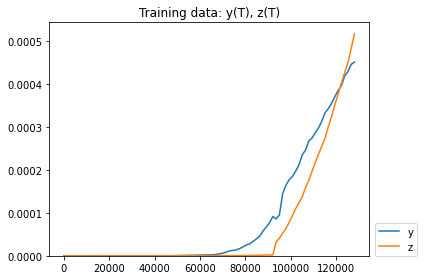

In [19]:
myVis.line_plot(
    train_df.set_index("T").drop("x", axis=1),
    "Training data: y(T), z(T)", math_scale=False, ylabel=""
)

### Example of non-dimensional SIR model
For example, set $R_0 = 2.5, \rho=0.2$.

In [20]:
eg_r0, eg_rho = (2.5, 0.2)
eg_sigma = eg_rho / eg_r0
(eg_rho, eg_sigma)

(0.2, 0.08)

In [21]:
%%time
eg_df = simulation(SIR, train_initials, step_n=200, rho=eg_rho, sigma=eg_sigma)

Wall time: 12 ms


In [22]:
eg_df.tail()

,t,x,y,z
196,196,0.116477,0.025188,0.858335
197,197,0.115918,0.023800,0.860282
198,198,0.115391,0.022486,0.862123
199,199,0.114894,0.021242,0.863864
200,200,0.114423,0.020064,0.865513


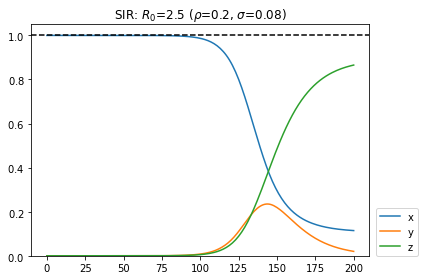

In [23]:
myVis.line_plot(
    eg_df.set_index("t"),
    title=r"SIR: $R_0$={0} ($\rho$={1}, $\sigma$={2})".format(eg_r0, eg_rho, eg_sigma),
    ylabel="",
    h=1
)


In [24]:
%%time
sir_estimator = Estimator(SIR, dfData,  popData.loc['Ontario'].population)

Wall time: 17 ms


In [25]:
sir_dict = sir_estimator.run()

In [26]:
sir_dict

{'tau': 1191,
 'rho': 0.0679574265246901,
 'sigma': 0.04160415236045736,
 'R0': 1.63,
 'score': 4.863521180973197,
 '1/beta [day]': 12,
 '1/gamma [day]': 19}

In [27]:
pd.DataFrame.from_dict({"SIR": sir_dict}, orient="index")

,tau,rho,sigma,R0,score,1/beta [day],1/gamma [day]
SIR,1191,0.067957,0.041604,1.63,4.863521,12,19


C:\Users\HP\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:164: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



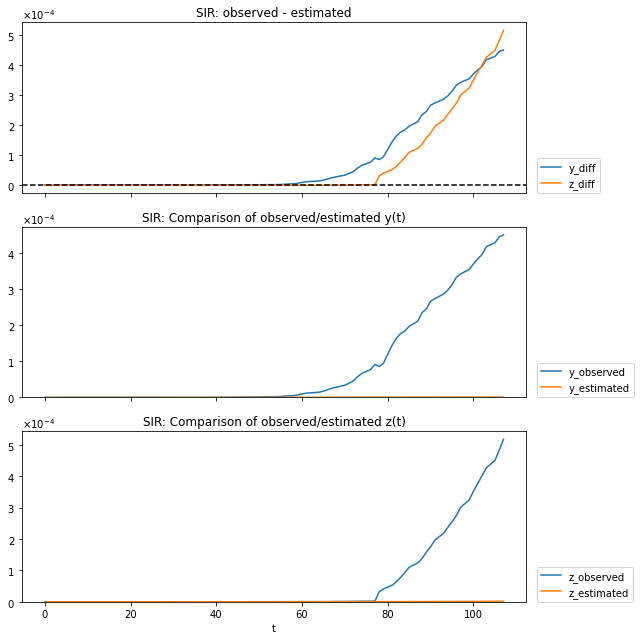

In [28]:
sir_estimator.compare_graph()

The modeling is very poor.  Let's try and refine the date to only consider a subset of the data.